### High-level Summary Statistics on Custodial Deaths in Texas

The goal of this notebook is to provide an overview of the impact of the COVID-19 pandemic on custodial deaths in Texas. 

In [84]:
import pandas as pd
import numpy as np
import datadotworld as dw
import matplotlib.pyplot as plt
import pygsheets
import requests
import json
from sodapy import Socrata
import re
from matplotlib.ticker import PercentFormatter

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [85]:
%watermark -a 'Lukas Hager' -v -p pandas,datadotworld

Author: Lukas Hager

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas      : 1.1.3
datadotworld: 1.7.0



We read in the data from data.world

In [86]:
files = dw.load_dataset('tji/deaths-in-custody').dataframes
cdr_raw = files['cleaned_custodial_death_reports']

/Users/hlukas/opt/anaconda3/lib/python3.8/site-packages/datadotworld/datadotworld.py:188: UserWarning: You are using an outdated copy of tji/deaths-in-custody. If you wish to use the latest version, call this function with the argument auto_update=True or force_update=True
  warn('You are using an outdated copy of {}. '
/Users/hlukas/opt/anaconda3/lib/python3.8/site-packages/datadotworld/models/dataset.py:206: UserWarning: Unable to set data frame dtypes automatically using cleaned_custodial_death_reports schema. Data types may need to be adjusted manually. Error: Bool column has NA values in column 27
  warnings.warn(


In [87]:
cdr_raw['report_date'] = pd.to_datetime(cdr_raw['report_date'])
cdr_raw['date_of_birth'] = pd.to_datetime(cdr_raw['date_of_birth'])
cdr_raw['death_date_and_time'] = pd.to_datetime(cdr_raw['death_date_and_time'])
cdr_raw['report_year'] = pd.DatetimeIndex(cdr_raw['report_date']).year.fillna(0)
cdr_raw['report_year'] = cdr_raw['report_year'].astype('int')
cdr_raw = cdr_raw.loc[cdr_raw['report_year'] > 0]
cdr_raw.head()

,record_id,num_revisions,form_version,report_date,date_time_of_custody_or_incident,name_first,name_last,name_middle,name_suffix,name_full,date_of_birth,age_at_time_of_death,sex,race,death_date,death_date_and_time,death_location_county,death_location_city,death_location_street_address,death_location_type,death_location_type_other,death_from_pre_existing_medical_condition,manner_of_death,manner_of_death_description,means_of_death,means_of_death_other,medical_cause_of_death,medical_examinor_coroner_evalution,medical_treatment,days_from_custody_to_death,who_caused_death_in_homicide_or_accident,who_caused_death_in_homicide_or_accident_other,offense_1,offense_2,offense_3,type_of_offense,type_of_offense_other,were_the_charges,facility_entry_date_time,type_of_custody,specific_type_of_custody_facility,agency_address,agency_city,agency_county,agency_name,agency_zip,type_of_restraint,under_restraint,entry_behavior,other_behavior,exhibit_any_medical_problems,exhibit_any_mental_health_problems,make_suicidal_statements,report_year
0,PA16489PF,0.0,V_2005,2016-10-25 13:05:00,2016-01-28T20:01:00,JOSHUA,TOYIN OLUBUNMI,NaN,NaN,JOSHUA TOYIN OLUBUNMI,1962-06-01,54.0,FEMALE,OTHER,2016-10-24T00:00:00,2016-10-24 23:18:00,HASKELL,HASKELL,1 AVENUE N,MEDICAL FACILITY,NaN,UNKNOWN,NATURAL CAUSES/ILLNESS,PENDING,NOT APPLICABLE,NaN,AUTOPSY PENDING,False,YES,270.0,NOT APPLICABLE,NaN,FAIL TO ID,PASSING COUNTERFEIT MONEY,NaN,NaN,FRAUD,CONVICTED,2016-10-24T22:40:00,PRIVATE FACILITY,OTHER,118 CR 206,HASKELL,HASKELL,ROLLING PLAINS REGIONAL JAIL AND DETENTION CENTER,79521.0,NaN,NO,NaN,NaN,NaN,NaN,NaN,2016
1,PA15069C,0.0,V_2005,2015-02-19 09:51:00,2015-02-03T11:45:00,WILBER,GONGORA,CASTILLO,NaN,WILBER CASTILLO GONGORA,1980-01-09,35.0,MALE,HISPANIC,2015-02-04T00:00:00,2015-02-04 19:42:00,WICHITA,ELECTRA,U.S. 287 @ U.S. 287 BUS H,MEDICAL FACILITY,NaN,UNKNOWN,"OTHER, SPECIFY",RULED NOT DETERMINED BY MEDICAL EXAMINER,"OTHER, SPECIFY",UNKNOWN,HYPERTENSIVE HEART DISEASE WITH METHAMPHETMAIN...,True,NOT APPLICABLE,1.0,UNKNOWN,NaN,EVADING ARREST/DETENTION,RESISTING ARREST,NaN,NaN,OBSTRUCTION OF GOVERNMENTAL OPERATION,NOT FILED AT TIME OF DEATH,NaN,POLICE CUSTODY (PRE-BOOKING),CUSTODY OF LAW ENFORCEMENT PERSONNEL DURING/FL...,P. O. BOX 8466,WICHITA FALLS,WICHITA,WICHITA CO SHERIFFS OFFICE,76307.0,NaN,YES,NaN,NaN,NaN,NaN,NaN,2015
2,PA06004CJ,0.0,V_2005,2006-02-16 15:26:00,2004-01-11T12:00:00,RUBEN,BLANCO-POTT,ALBERTO,NaN,RUBEN ALBERTO BLANCO-POTT,1968-05-07,37.0,MALE,OTHER,2006-01-05T00:00:00,2006-01-05 02:45:00,KARNES,KARNES CITY,810 COMMERCE ST.,MEDICAL FACILITY,NaN,YES,NATURAL CAUSES/ILLNESS,AIDS SYNDROME / URINARY SEPSIS,NOT APPLICABLE,NaN,AIDS SYNDROME / URINARY SEPSIS,False,YES,724.0,NOT APPLICABLE,NaN,ILLEGAL REENTRY,NaN,NaN,NaN,ILLEGAL REENTRY,CONVICTED,2004-01-11T12:00:00,JAIL - COUNTY,HOSPITAL/INFIRMARY,113 N. PANNA MARIA ST.,KARNES CITY,KARNES,KARNES CO SHERIFFS OFFICE,78118.0,NaN,NO,MEDICAL,NaN,NaN,NaN,NaN,2006
3,20-128-P,0.0,V_2016,2020-02-20 00:00:00,1997-08-16T00:00:00,BILLY,WALLACE,WAYNE,NaN,BILLY WAYNE WALLACE,1947-11-07,72.0,MALE,WHITE,2020-01-24T00:00:00,2020-01-24 16:09:00,LUBBOCK,LUBBOCK,8602 PEACH AVE,MEDICAL FACILITY,NaN,UNKNOWN,NATURAL CAUSES/ILLNESS,NaN,NOT APPLICABLE,NaN,CARDIAC ARREST SECOND TO CVA AND SEPSIS,False,YES,8196.0,NOT APPLICABLE,NaN,INDECENCY WITH A CHILD,NaN,NaN,CRIMES AGAINST CHILD(REN),NaN,CONVICTED,1997-08-16T00:00:00,PRISON,TDCJ,1012 VETERANS MEMORIAL PARKWAY,HUNTSVILLE,STATE,TEXAS DEPT OF CRIMINAL JUSTICE,77320.0,NaN,NO,NaN,NaN,YES,UNKNOWN,UNKNOWN,2020
4,20-144-P,0.0,V_2016,2020-02-21 00:00:00,1995-07-21T00:00:00,LEWIS,BROWN,MONTROY,NaN,LEWIS MONTROY BROWN,1975-01-19,45.0,MALE,BLACK,2020-02-07T00:00:00,2020-02-07 07:22:00,ANDERSON,TENNESSEE COLONY,2661 FM 2054,MEDICAL FACILITY,NaN,NOT APPLICABLE,"OTHER, SPECIFY",PENDING AUTOPSY RESULTS,DRUG OVERDOSE,NaN,UNKNOWN,True,UNKNOWN,8967.0,UNKNOWN,NaN,AGGRAVATED SEXUAL ASSAULT OF A CHILD,AGGRAVATED SEXUAL ASSAULT,NaN,VIOLENT CRIME AGAINST PERSONS; CRIMES AGAINST ...,NaN,CONVICTED,1995-07-21

In [88]:
deaths_by_year = cdr_raw.groupby('report_year')[['record_id']]
deaths_by_year = deaths_by_year.agg('count')
deaths_by_year = deaths_by_year.rename(columns={'record_id':'total_deaths'})

<AxesSubplot:xlabel='report_year'>

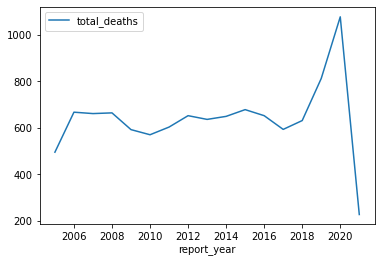

In [89]:
deaths_by_year.plot()

It's pretty clear that 2020 was the most fatal year on record for Texas inmates. However, correlation of course does not imply causation. One thing that we can look at is the distribution of deaths by age, as COVID-19 is progressively more fatal as the age of the host increases.

In [90]:
deaths_by_age = cdr_raw.copy().loc[cdr_raw['report_year'].isin([2019,2020])]
deaths_by_age['age_bin'] = np.floor(deaths_by_age['age_at_time_of_death'] / 10) * 10

deaths_by_age = deaths_by_age.groupby(['age_bin', 'report_year'], as_index = False)[['record_id']]
deaths_by_age = deaths_by_age.agg('nunique')
deaths_by_age = deaths_by_age.rename(columns={'record_id':'total_deaths'})

# remove a negative value
deaths_by_age = deaths_by_age.loc[deaths_by_age['age_bin'] >= 0]

# pivot data
deaths_by_age = deaths_by_age.pivot(index='age_bin', columns='report_year', values='total_deaths').reset_index()

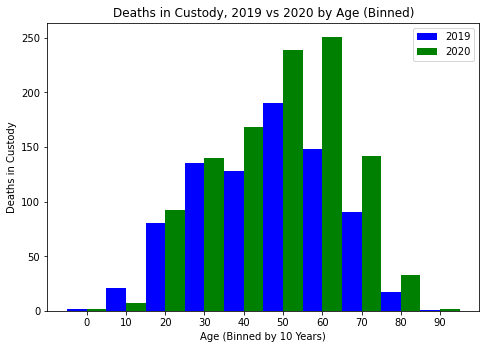

In [91]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(deaths_by_age['age_bin'] + -2.5, deaths_by_age[2019], color = 'b', width = 5)
ax.bar(deaths_by_age['age_bin'] + 2.5, deaths_by_age[2020], color = 'g', width = 5)
ax.set_title('Deaths in Custody, 2019 vs 2020 by Age (Binned)')
ax.set_xlabel('Age (Binned by 10 Years)')
ax.set_ylabel('Deaths in Custody')
ax.xaxis.set_ticks(ticks = np.arange(0, 100, 10))
ax.legend(labels=['2019', '2020']);

So it's pretty clear that the significant change in deaths (at least compared to the prior year) is occurring in older prisoners, which is consistent with a COVID-19 theory. What do we know about the manner of death?

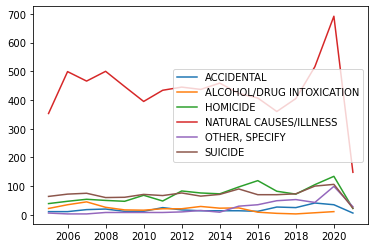

In [92]:
deaths_by_manner = cdr_raw.copy()
deaths_by_manner = deaths_by_manner.groupby(['manner_of_death', 'report_year'], as_index = False)[['record_id']]
deaths_by_manner = deaths_by_manner.agg('nunique')
deaths_by_manner

for death_val in deaths_by_manner['manner_of_death'].unique():
    sub_df = deaths_by_manner.copy().loc[deaths_by_manner['manner_of_death'] == death_val]
    plt.plot(sub_df['report_year'], sub_df['record_id'], label = death_val)
    
plt.legend()
plt.show()

Illness is overshadowing everything else, so what do we have when we remove it?

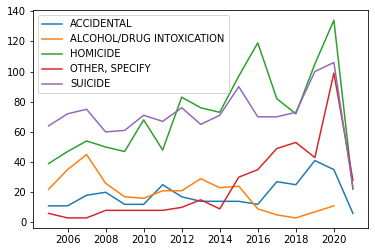

In [93]:
for death_val in deaths_by_manner['manner_of_death'].unique():
    if death_val != 'NATURAL CAUSES/ILLNESS':
        sub_df = deaths_by_manner.copy().loc[deaths_by_manner['manner_of_death'] == death_val]
        plt.plot(sub_df['report_year'], sub_df['record_id'], label = death_val)
    
plt.legend()
plt.show()

There's a big spike in "Other" -- let's look at the subcategory here. There's a COVID description!

In [94]:
cdr_raw.loc[cdr_raw['manner_of_death_description'] == 'COVID']['record_id'].count()

1

There aren't that many, shocking. I'm not sure the best way to parse the other field medically.

### More stuff to do

Here are analyses:

- Can we marry the Vera data in somehow to get a sense of how the jail's population is associated with COVID? Are predominantly whiter/richer jails less COVID-prone? We should also normalize by jail census to the degree that we can (i.e. show that the increases aren't a result of having like 1.25 as many people incarcarated)
- Do we want to try to estimate the impact of COVID on death in jails? How accurate can we be?
- Break down by pre-trial deaths?
- Can we get data on the jail's county and how they were impacted by COVID? Are jail COVID situations reflective of county characteristics, or are they worse (or I guess better maybe, but that seems less likely)
- Time trends of death vs Texas at large. Can we formulate any sort of "deaths above expectation" measure that we can feel comfortable with? Probably not?
- Can we diff-in-diff at all with COVID? How powerful will these estimates be?

Medical cause of death field?

In [95]:
covid_match = cdr_raw.loc[cdr_raw['medical_cause_of_death'].str.upper().str.match('COVID') == True]
len(covid_match.index)

97

In [96]:
covid_match['medical_cause_of_death'].value_counts()

COVID-19 PNEUMONIA                                                                                                             26
COVID-19                                                                                                                       18
COVID 19 PNEUMONIA                                                                                                             12
COVID PNEUMONIA                                                                                                                 4
COVID-19 VIRUS RELATED                                                                                                          2
COVID-19 COMPLICATIONS                                                                                                          2
COVID-19 RELATED PNEUMONIA                                                                                                      2
COVID 19                                                                                  

Read in COVID deaths from Eva

In [97]:
gc = pygsheets.authorize('/Users/hlukas/git/_header/client_secret.json')

In [98]:
gc.drive.enable_team_drive('0ACeQWapAwOLqUk9PVA')
output = gc.open_by_url('https://docs.google.com/spreadsheets/d/1mOS1wggvyRUOpI-u2VabmnQ1yJPPEgOc2zdZjWxbAwQ/edit#gid=0')
wk = output[0]
covid_deaths = wk.get_as_df(include_tailing_empty = True)

In [99]:
covid_deaths.head()

,no.,DateofDeath,Date Entered,Name,Gender,Race,Age,FacilityType,Facility,City,County,Geolocation,source,CDR link,CDR summary,CDR medical cause,media,Sentencing County,,,,,,,,,,,,,,,,,,,
0,1,unknown,6/1/2020,unknown,unknown,unknown,unknown,Federal Residential Reentry Center,"Volunteers of America Texas, Inc.",Fort Worth,Tarrant,"32.62636422034036, -96.71072775678357",BOP data,N/A,N/A,N/A,,,,,,,,,,,,,,,,,,,,,
1,2,4/2/2020,11/9/2020,Alton Ray Stakely,Male,Anglo or White,72,State Prison,Telford Unit,New Boston,Bowie,"33.4599765408031, -94.4149296203967",CDR,https://oagtx.force.com/cdr/VIPForm__VIP_FormW...,"On March 19, 2020, Offender was transported to...",E.coli sepsis due to anastomotic dehiscence of...,,,,,,,,,,,,,,,,,,,,,
2,3,4/7/2020,4/8/2020,Bartolo Infante,Male,Hispanic or Latino,72,State Prison,Telford Unit,New Boston,Bowie,"33.4599765408031, -94.4149296203967","TDCJ, CDR",https://oagtx.force.com/cdr/VIPForm__VIP_FormW...,"On April 3, 2020, Offender was admitted to Wad...",Complications from COVID-19,Texas Tribune,,,,,,,,,,,,,,,,,,,,
3,4,4/11/2020,4/14/2020,Eugene Leonard Clerkly,Male,Black or African American,62,State Prison,Pack Unit,Navasota,Grimes,"30.3246933217809, -96.1057160493166","TDCJ, CDR",https://oagtx.force.com/cdr/VIPForm__VIP_FormW...,"On April 11, 2020, the offender was being tran...",Cardiac arrest,Huntsville Item,Hidalgo,,,,,,,,,,,,,,,,,,,
4,5,4/13/2020,4/30/2020,James Matthews,Male,Anglo or White,68,State Prison,Beto Unit,Tennessee Colony,Anderson,"31.7549439691523, -95.8226644474331","TDCJ, CDR",https://oagtx.force.com/cdr/VIPForm__VIP_FormW...,"On April 13, 2020, at 1:33 PM, an Offender who...",Undetermined at this time. Offender had tested...,Tyler Morning Telegraph,Bell,,,,,,,,,,,,,,,,,,,


How many deaths are listed here?

In [100]:
print('There are {} deaths listed'.format(covid_deaths.shape[0]))

There are 349 deaths listed


Convert date of death to date

In [101]:
covid_deaths['death_date'] = pd.to_datetime(covid_deaths['DateofDeath'], 
                                            format = '%m/%d/%Y',
                                            errors = 'coerce')
covid_deaths['death_date'].describe()

<ipython-input-101-e920bef6fcb9>:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  covid_deaths['death_date'].describe()


count                     343
unique                    193
top       2020-05-28 00:00:00
freq                        6
first     2020-04-02 00:00:00
last      2021-05-08 00:00:00
Name: death_date, dtype: object

In [102]:
covid_deaths['death_date'][1].year

2020

In [103]:
covid_deaths['age_num'] = pd.to_numeric(covid_deaths['Age'], errors='coerce')
covid_deaths['age_bin'] = np.floor(covid_deaths['age_num'] / 10) * 10

# remove deaths that occurred after 2020
covid_summ = covid_deaths.copy()
covid_summ = covid_summ.loc[covid_summ['death_date'] <= '2020-12-31']
covid_summ = pd.DataFrame(covid_summ['age_bin'].value_counts()).reset_index().rename(columns={'index': 'age_bin',
                                                                                              'age_bin': 'counts'})

full_age_data = deaths_by_age.set_index('age_bin').join(covid_summ.set_index('age_bin'), how = 'left').fillna(0)
full_age_data = full_age_data.reset_index()

Replicate the earlier plot

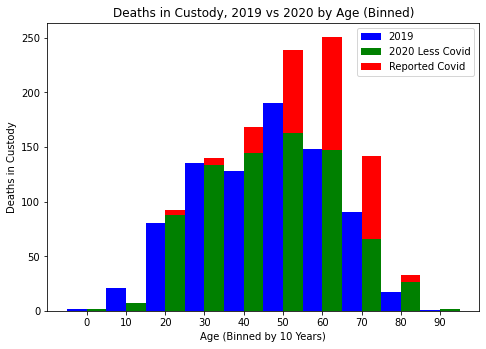

In [104]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(full_age_data['age_bin'] + -2.5, full_age_data[2019], color = 'b', width = 5)
ax.bar(full_age_data['age_bin'] + 2.5, full_age_data[2020] - full_age_data['counts'], color = 'g', width = 5)
ax.bar(full_age_data['age_bin'] + 2.5, full_age_data['counts'], color = 'r', width = 5,
       bottom = full_age_data[2020] - full_age_data['counts'])
ax.set_title('Deaths in Custody, 2019 vs 2020 by Age (Binned)')
ax.set_xlabel('Age (Binned by 10 Years)')
ax.set_ylabel('Deaths in Custody')
ax.xaxis.set_ticks(ticks = np.arange(0, 100, 10))
ax.legend(labels=['2019', '2020 Less Covid', 'Reported Covid'])

### Compare to Vera Data

Pull in Vera data

In [105]:
vera_data_pops = pd.read_csv('https://raw.githubusercontent.com/vera-institute/incarceration-trends/master/incarceration_trends_jail_jurisdiction.csv')

In [106]:
vera_data_cty = pd.read_csv('https://raw.githubusercontent.com/vera-institute/incarceration-trends/master/incarceration_trends.csv')

In [107]:
vera_tx = vera_data_cty[['year', 'state', 'county_name', 'total_jail_pop']]
vera_tx = vera_tx.loc[(vera_tx['state'] == 'TX') & (vera_tx['year'] == 2018)]
vera_tx['county'] = vera_tx['county_name'].str.extract(r'(.*)(?= County)')
vera_tx['county'] = vera_tx['county'].str.upper()
vera_tx

,year,state,county_name,total_jail_pop,county
123528,2018,TX,Anderson County,182.00,ANDERSON
123577,2018,TX,Andrews County,22.00,ANDREWS
123626,2018,TX,Angelina County,244.00,ANGELINA
123675,2018,TX,Aransas County,195.00,ARANSAS
123724,2018,TX,Archer County,18.93,ARCHER
123773,2018,TX,Armstrong County,3.00,ARMSTRONG
123822,2018,TX,Atascosa County,114.00,ATASCOSA
123871,2018,TX,Austin County,50.00,AUSTIN
123920,2018,TX,Bailey County,41.00,BAILEY
123969,2018,TX,Bandera County,54.00,BANDERA


Use the last populated jail census for each jail

In [108]:
vera_data_pops_rel = vera_data_pops.copy().loc[pd.isna(vera_data_pops['total_jail_pop']) == False]
latest_year = vera_data_pops_rel.groupby(['jid', 'fips'], as_index = False)[['jid', 'fips', 'year']].max()
latest_year = latest_year.loc[latest_year['year'] >= 2010].rename(columns = {'year': 'max_year'})

vera_data_pops_late = vera_data_pops.copy().set_index(['jid', 'fips']).join(latest_year.set_index(['jid', 'fips']))
vera_data_pops_late = vera_data_pops_late.loc[vera_data_pops_late['max_year'] == vera_data_pops_late['year']].reset_index()
vera_data_pops_late['year'].value_counts()

2018    2972
Name: year, dtype: int64

Define a function to use census API to get FIPS code

In [109]:
def get_fips(lat,long):
    qs = 'https://geo.fcc.gov/api/census/area?lat={}&lon={}&format=json'.format(lat, long)
    out = requests.get(qs)
    return([json.loads(out.text)['results'][0]['county_fips'],
            json.loads(out.text)['results'][0]['county_name']])

In [110]:
fips_decoded = []
county_decoded = []
for loc in covid_deaths['Geolocation']:
    split = loc.split(', ')
    lat = split[0]
    long = split[1]
    fips_decoded.append(get_fips(lat,long)[0])
    county_decoded.append(get_fips(lat,long)[1])

In [111]:
covid_deaths['fips_decoded'] = fips_decoded
covid_deaths['county'] = county_decoded

Read in the Texas Deaths Data by County

In [112]:
str_name = 'https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyFatalityCountData.xlsx'

county_data = pd.read_excel(str_name, 
                            header = 2)

In [113]:
county_data.head()

,County Name,Fatalities 03-07-2020,Fatalities 03-08-2020,Fatalities 03-09-2020,Fatalities 03-10-2020,Fatalities 03-11-2020,Fatalities 03-12-2020,Fatalities 03-13-2020,Fatalities 03-14-2020,Fatalities 03-15-2020,Fatalities 03-16-2020,Fatalities 03-17-2020,Fatalities 03-18-2020,Fatalities 03-19-2020,Fatalities 03-20-2020,Fatalities 03-21-2020,Fatalities 03-22-2020,Fatalities 03-23-2020,Fatalities 03-24-2020,Fatalities 03-25-2020,Fatalities 03-26-2020,Fatalities 03-27-2020,Fatalities 03-28-2020,Fatalities 03-29-2020,Fatalities 03-30-2020,Fatalities 03-31-2020,Fatalities 04-01-2020,Fatalities 04-02-2020,Fatalities 04-03-2020,Fatalities 04-04-2020,Fatalities 04-05-2020,Fatalities 04-06-2020,Fatalities 04-07-2020,Fatalities 04-08-2020,Fatalities 04-09-2020,Fatalities 04-10-2020,Fatalities 04-11-2020,Fatalities 04-12-2020,Fatalities 04-13-2020,Fatalities 04-14-2020,Fatalities 04-15-2020,Fatalities 04-16-2020,Fatalities 04-17-2020,Fatalities 04-18-2020,Fatalities 04-19-2020,Fatalities 04-20-2020,Fatalities 04-21-2020,Fatalities 04-22-2020,Fatalities 04-23-2020,Fatalities 04-24-2020,Fatalities 04-25-2020,Fatalities 04-26-2020,Fatalities 04-27-2020,Fatalities 04-28-2020,Fatalities 04-29-2020,Fatalities 04-30-2020,Fatalities 05-01-2020,Fatalities 05-02-2020,Fatalities 05-03-2020,Fatalities 05-04-2020,Fatalities 05-05-2020,Fatalities 05-06-2020,Fatalities 05-07-2020,Fatalities 05-08-2020,Fatalities 05-09-2020,Fatalities 05-10-2020,Fatalities 05-11-2020,Fatalities 05-12-2020,Fatalities 05-13-2020,Fatalities 05-14-2020,Fatalities 05-15-2020,Fatalities 05-16-2020,Fatalities 05-17-2020,Fatalities 05-18-2020,Fatalities 05-19-2020,Fatalities 05-20-2020,Fatalities 05-21-2020,Fatalities 05-22-2020,Fatalities 05-23-2020,Fatalities 05-24-2020,Fatalities 05-25-2020,Fatalities 05-26-2020,Fatalities 05-27-2020,Fatalities 05-28-2020,Fatalities 05-29-2020,Fatalities 05-30-2020,Fatalities 05-31-2020,Fatalities 06-01-2020,Fatalities 06-02-2020,Fatalities 06-03-2020,Fatalities 06-04-2020,Fatalities 06-05-2020,Fatalities 06-06-2020,Fatalities 06-07-2020,Fatalities 06-08-2020,Fatalities 06-09-2020,Fatalities 06-10-2020,Fatalities 06-11-2020,Fatalities 06-12-2020,Fatalities 06-13-2020,Fatalities 06-14-2020,Fatalities 06-15-2020,Fatalities 06-16-2020,Fatalities 06-17-2020,Fatalities 06-18-2020,Fatalities 06-19-2020,Fatalities 06-20-2020,Fatalities 06-21-2020,Fatalities 06-22-2020,Fatalities 06-23-2020,Fatalities 06-24-2020,Fatalities 06-25-2020,Fatalities 06-26-2020,Fatalities 06-27-2020,Fatalities 06-28-2020,Fatalities 06-29-2020,Fatalities 06-30-2020,Fatalities 07-01-2020,Fatalities 07-02-2020,Fatalities 07-03-2020,Fatalities 07-04-2020,Fatalities 07-05-2020,Fatalities 07-06-2020,Fatalities 07-07-2020,Fatalities 07-08-2020,Fatalities 07-09-2020,Fatalities 07-10-2020,Fatalities 07-11-2020,Fatalities 07-12-2020,Fatalities 07-13-2020,Fatalities 07-14-2020,Fatalities 07-15-2020,Fatalities 07-16-2020,Fatalities 07-17-2020,Fatalities 07-18-2020,Fatalities 07-19-2020,Fatalities 07-20-2020,Fatalities 07-21-2020,Fatalities 07-22-2020,Fatalities 07-23-2020,Fatalities 07-24-2020,Fatalities 07-25-2020,Fatalities 07-26-2020,Fatalities 07-27-2020,Fatalities 07-28-2020,Fatalities 07-29-2020,Fatalities 07-30-2020,Fatalities 07-31-2020,Fatalities 08-01-2020,Fatalities 08-02-2020,Fatalities 08-03-2020,Fatalities 08-04-2020,Fatalities 08-05-2020,Fatalities 08-06-2020,Fatalities 08-07-2020,Fatalities 08-08-2020,Fatalities 08-09-2020,Fatalities 08-10-2020,Fatalities 08-11-2020,Fatalities 08-12-2020,Fatalities 08-13-2020,Fatalities 08-14-2020,Fatalities 08-15-2020,Fatalities 08-16-2020,Fatalities 08-17-2020,Fatalities 08-18-2020,Fatalities 08-19-2020,Fatalities 08-20-2020,Fatalities 08-21-2020,Fatalities 08-22-2020,Fatalities 08-23-2020,Fatalities 08-24-2020,Fatalities 08-25-2020,Fatalities 08-26-2020,Fatalities 08-27-2020,Fatalities 08-28-2020,Fatalities 08-29-2020,Fatalities 08-30-2020,Fatalities 08-31-2020,Fatalities 09-01-2020,Fatalities 09-02-2020,Fatalities 09-03-2020,Fatal

The data is cumulative, so we want the 12/31 variable

In [114]:
covid_death_county = county_data.copy()[['County Name', 'Fatalities 12-31-2020']]

We also need Census Data estimates of population by county

In [115]:
#qs = 'https://api.census.gov/data/2019/acs/acs5?key=dbdcf56ed39f351aba8093a27cb1e19f1f3ac043&get=B01003_001E&for='
qs = 'https://api.census.gov/data/2019/pep/population?get=NAME,DATE_DESC,POP,STATE&for=county:*&for=state:48&key='
resp = json.loads(requests.get('{}dbdcf56ed39f351aba8093a27cb1e19f1f3ac043'.format(qs)).text)
pop_df = pd.DataFrame(data = resp[1:],
                         columns = resp[0])

# # rename
# income_df.rename(columns={0: 'med_income', 1: 'state', 2: 'zip_code'}, inplace=True)
# # drop the headers
# income_df.drop(income_df.index[0], inplace=True)
# # filter to TX
# income_df = income_df.loc[income_df.state == '48']
# # cast median income as integer and zip as string
# income_df['med_income'] = income_df['med_income'].astype('float')
# income_df['zip_code'] = income_df['zip_code'].astype('str')


In [116]:
tx_pop = pop_df.copy().loc[pop_df['STATE'] == '48']
tx_pop['county'] = tx_pop['NAME'].str.extract(r'(.*)(?= County)')
tx_pop['county'] = tx_pop['county'].str.upper()
tx_pop['POP'] = tx_pop['POP'].astype('int')

In [117]:
tx_pop[['county', 'POP']]

,county,POP
124,MARTIN,5771
125,WICHITA,132230
128,POLK,51353
129,REAGAN,3849
130,REFUGIO,6948
131,SHELBY,25274
132,RED RIVER,12023
133,RUNNELS,10264
134,TOM GREEN,119200
135,CALDWELL,43664


Combine and calculate COVID fatality rate

In [118]:
tx_pop_fatality = tx_pop.set_index('county').join(covid_death_county.set_index('County Name'),
                                                  how = 'left')
tx_pop_fatality = tx_pop_fatality[['NAME', 'POP', 'Fatalities 12-31-2020']].reset_index()
tx_pop_fatality['death_rate'] = tx_pop_fatality['Fatalities 12-31-2020'] / tx_pop_fatality['POP']

In [119]:
tx_pop_fatality.sort_values(by = 'NAME')

,county,NAME,POP,Fatalities 12-31-2020,death_rate
200,ANDERSON,"Anderson County, Texas",57735,73.0,1.26e-03
174,ANDREWS,"Andrews County, Texas",18705,33.0,1.76e-03
75,ANGELINA,"Angelina County, Texas",86715,166.0,1.91e-03
238,ARANSAS,"Aransas County, Texas",23510,25.0,1.06e-03
28,ARCHER,"Archer County, Texas",8553,6.0,7.02e-04
108,ARMSTRONG,"Armstrong County, Texas",1887,6.0,3.18e-03
80,ATASCOSA,"Atascosa County, Texas",51153,88.0,1.72e-03
214,AUSTIN,"Austin County, Texas",30032,15.0,4.99e-04
49,BAILEY,"Bailey County, Texas",7000,16.0,2.29e-03
126,BANDERA,"Bandera County, Texas",23112,15.0,6.49e-04


Merge this onto the COVID Deaths data

In [120]:
covid_deaths['county_upper'] = covid_deaths['county'].str.upper()
deaths_by_cty = covid_deaths.copy()
deaths_by_cty = deaths_by_cty.loc[deaths_by_cty['death_date'] <= '2020-12-31']

deaths_by_cty = deaths_by_cty[['county_upper', 'Name']].groupby(['county_upper'], 
                                                                as_index=False).count()
deaths_by_cty = deaths_by_cty.rename(columns={'Name': 'deaths'})


full_data_cty = deaths_by_cty.set_index('county_upper').join(tx_pop_fatality.set_index('county'),
                                                             how = 'outer')

full_data_cty = full_data_cty.join(vera_tx.set_index('county'),
                                   how = 'left')

full_data_cty['deaths'] = full_data_cty['deaths'].fillna(0)


In [121]:
# full_data_cty.loc[np.isnan(full_data_cty['total_jail_pop']) == False].sort_values('jail_covid_death_rate',
#                                                                                   ascending = False)

KeyError: 'jail_covid_death_rate'

Pull in the inmate population data

In [122]:
client = Socrata("data.texas.gov", None)
results = client.get("hvv5-kub4", limit=200000)
#inmates = pd.DataFrame(json.loads(requests.get('https://data.texas.gov/resource/hvv5-kub4.json').text))
inmates = pd.DataFrame.from_records(results)

In [123]:
inmates_by_jail = inmates.groupby('current_facility')[['tdcj_number']].nunique().reset_index()
inmates_by_jail

,current_facility,tdcj_number
0,Allred,3538
1,B. Moore,480
2,Bell,504
3,Beto,3130
4,Boyd,1320
5,Bridgeport,476
6,Briscoe,1132
7,Byrd,1147
8,C. Moore,1055
9,C.T. Terrell,1509


Now get counties

In [124]:
prison_counties = pd.read_csv('/Users/hlukas/git/tji/facility_locations.csv')
prison_counties

,Unit Name,Unit Code,Operator,Gender,Type,Region,City,County
0,Allred,JA,CID,Male,Prison,V,Iowa Park,Wichita
1,Bell,CV,MTC,Male,Private Prison,Private,Cleveland,Liberty
2,Beto,B,CID,Male,Prison,II,Tennessee Colony,Anderson
3,Boyd,BY,CID,Male,Prison,II,Teague,Freestone
4,Bridgeport,BR,MTC,Male,Private Prison,Private,Bridgeport,Wise
5,Briscoe,DB,CID,Male,Prison,IV,Dilley,Frio
6,Byrd,DU,CID,Male,Prison,I,Huntsville,Walker
7,Clemens,CN,CID,Male,Prison,III,Brazoria,Brazoria
8,Clements,BC,CID,Male,Prison,V,Amarillo,Potter
9,Coffield,CO,CID,Male,Prison,II,Tennessee Colony,Anderson


Fix names and merge

In [125]:
prison_counties['name_adj'] = np.select(
    [
        prison_counties['Unit Name'] == 'Moore, B.',
        prison_counties['Unit Name'] == 'Moore, C.',
        prison_counties['Unit Name'] == 'Terrell',
        prison_counties['Unit Name'] == 'East Texas',
        prison_counties['Unit Name'] == 'Montford/West Texas Hospital',
        prison_counties['Unit Name'] == 'Wallace/San Angelo Work Camp',
        prison_counties['Unit Name'] == 'Plane/Santa Maria Baby Bonding',
        prison_counties['Unit Name'] == 'LeBlanc'
    ],
    [
        'B. Moore',
        'C. Moore',
        'C.T. Terrell',
        'East Texas Treatment Facility',
        'Montford',
        'San Angelo Work Camp',
        'Santa Maria Baby Bonding',
        'Le Blanc'
    ],
    default=prison_counties['Unit Name']
)

inmates_counties = inmates_by_jail.set_index('current_facility').join(prison_counties.set_index('name_adj'),
                                                                      how = 'right').reset_index()
inmates_counties['County'] = inmates_counties['County'].str.upper()
inmates_counties = inmates_counties[['tdcj_number', 'County']].groupby(['County'],
                                                                        as_index = False).sum()
#inmates_counties.loc[pd.isna(inmates_counties['Unit Code'])]

Add on the inmate data

In [126]:
inmates_counties

,County,tdcj_number
0,ANDERSON,11215.0
1,ANGELINA,893.0
2,BEE,4323.0
3,BEXAR,1962.0
4,BOWIE,2828.0
5,BRAZORIA,7066.0
6,BRAZOS,783.0
7,BROWN,342.0
8,BURNET,261.0
9,CALDWELL,414.0


In [128]:
fuller_data_cty = full_data_cty.join(inmates_counties.set_index('County'), how = 'left')
fuller_data_cty['tdcj_number'] = fuller_data_cty['tdcj_number'].fillna(0)

In [135]:
fuller_data_cty['total_inmate_pop'] = fuller_data_cty['total_jail_pop'] + fuller_data_cty['tdcj_number']
fuller_data_cty['jail_covid_death_rate'] = fuller_data_cty['deaths'] / (fuller_data_cty['total_inmate_pop'])

In [149]:
fuller_data_cty

,deaths,NAME,POP,Fatalities 12-31-2020,death_rate,year,state,county_name,total_jail_pop,tdcj_number,jail_covid_death_rate,total_inmate_pop
ANDERSON,19.0,"Anderson County, Texas",5.77e+04,73.0,1.26e-03,2018.0,TX,Anderson County,182.00,11215.0,1.67e-03,11397.00
ANDREWS,0.0,"Andrews County, Texas",1.87e+04,33.0,1.76e-03,2018.0,TX,Andrews County,22.00,0.0,0.00e+00,22.00
ANGELINA,23.0,"Angelina County, Texas",8.67e+04,166.0,1.91e-03,2018.0,TX,Angelina County,244.00,893.0,2.02e-02,1137.00
ARANSAS,0.0,"Aransas County, Texas",2.35e+04,25.0,1.06e-03,2018.0,TX,Aransas County,195.00,0.0,0.00e+00,195.00
ARCHER,0.0,"Archer County, Texas",8.55e+03,6.0,7.02e-04,2018.0,TX,Archer County,18.93,0.0,0.00e+00,18.93
ARMSTRONG,0.0,"Armstrong County, Texas",1.89e+03,6.0,3.18e-03,2018.0,TX,Armstrong County,3.00,0.0,0.00e+00,3.00
ATASCOSA,0.0,"Atascosa County, Texas",5.12e+04,88.0,1.72e-03,2018.0,TX,Atascosa County,114.00,0.0,0.00e+00,114.00
AUSTIN,0.0,"Austin County, Texas",3.00e+04,15.0,4.99e-04,2018.0,TX,Austin County,50.00,0.0,0.00e+00,50.00
BAILEY,0.0,"Bailey County, Texas",7.00e+03,16.0,2.29e-03,2018.0,TX,Bailey County,41.00,0.0,0.00e+00,41.00
BANDERA,0.0,"Bandera County, Texas",2.31e+04,15.0,6.49e-04,2018.0,TX,Bandera County,54.00,0.0,0.00e+00,54.00


Plot the data

In [152]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

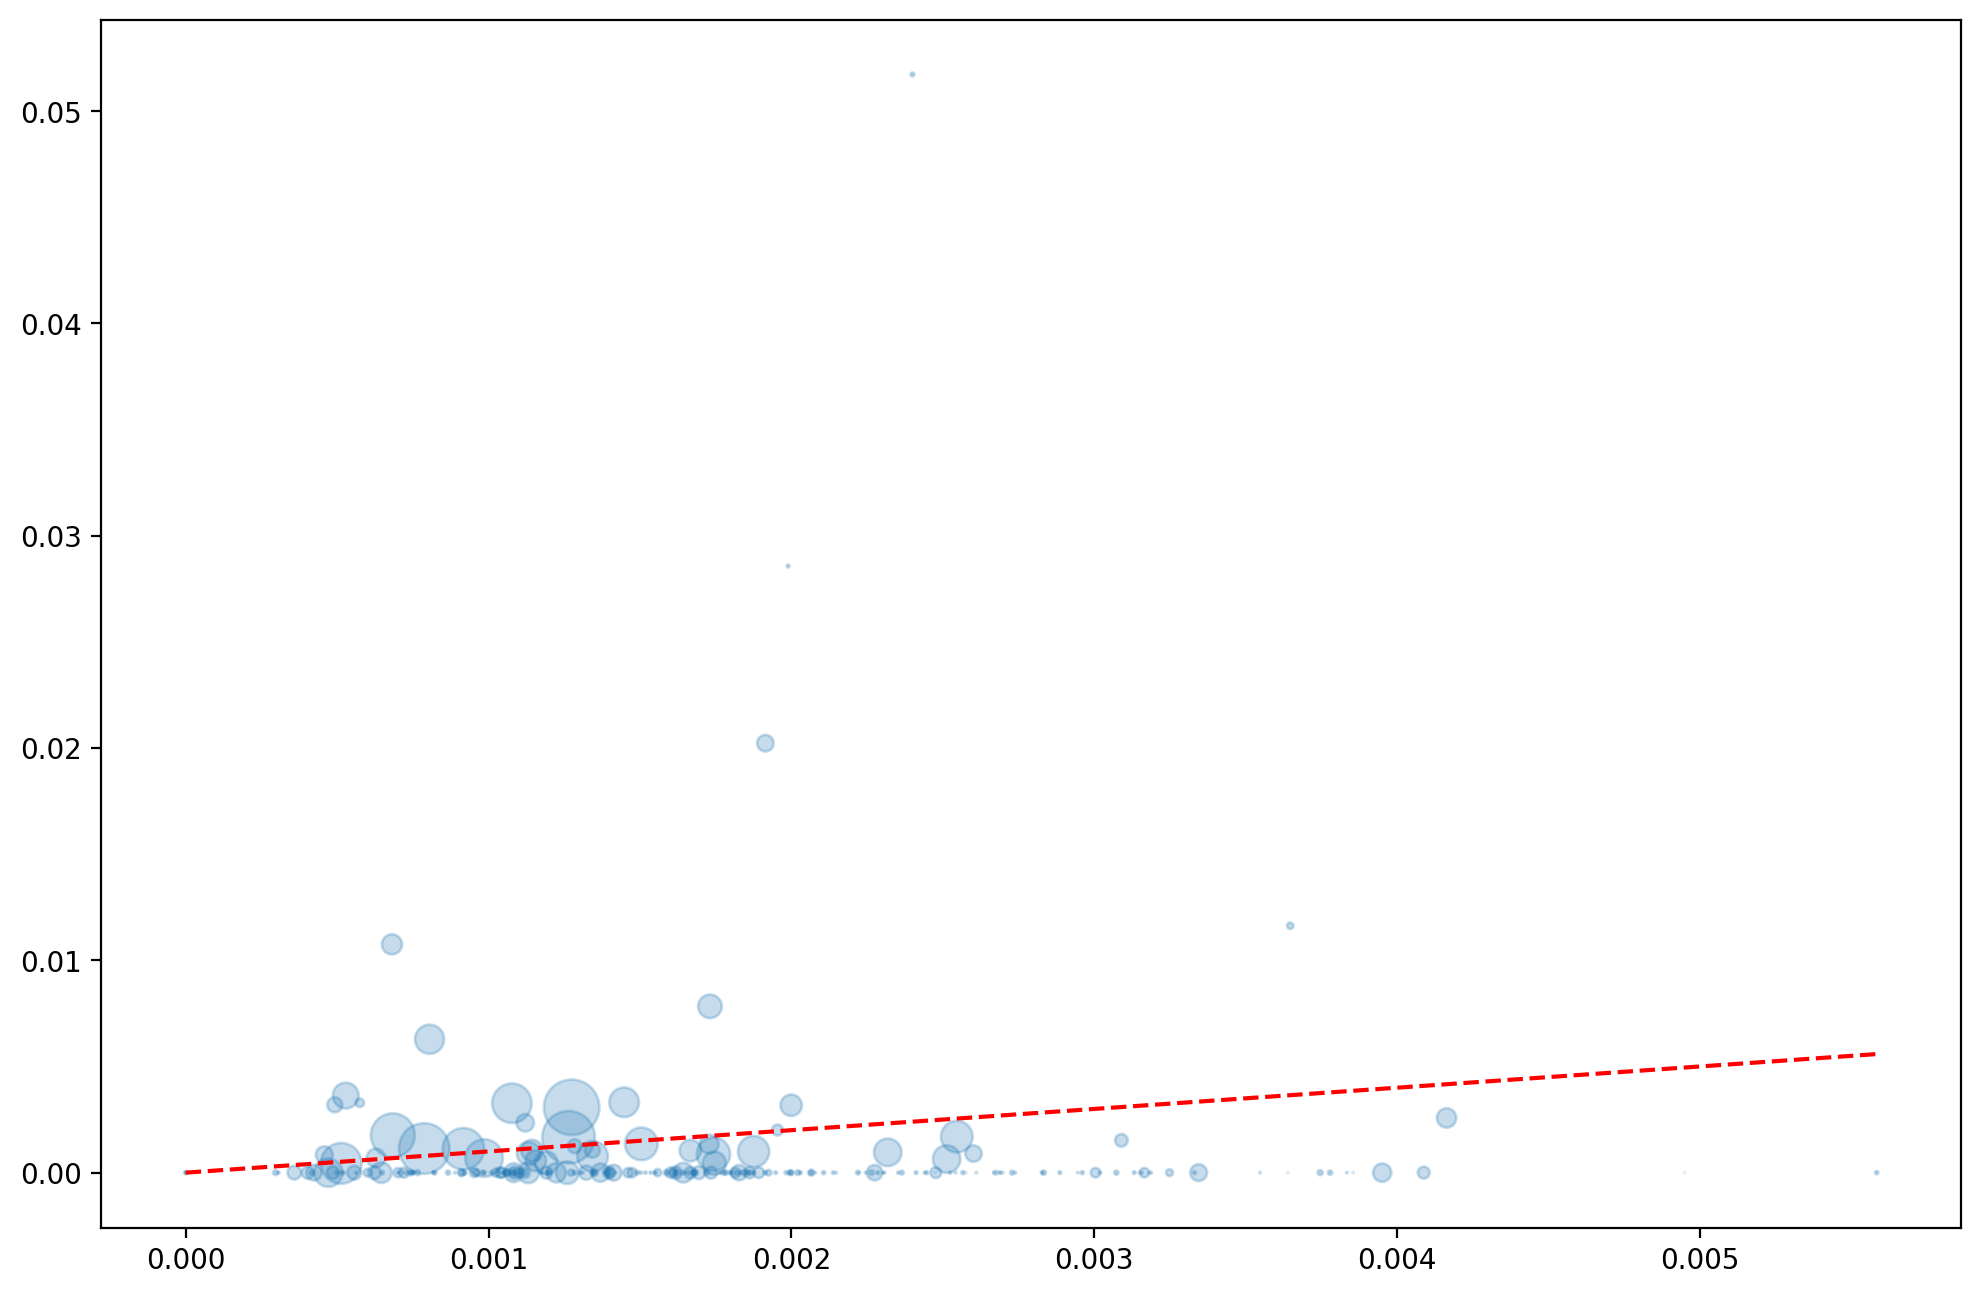

In [153]:
plt.scatter(fuller_data_cty['death_rate'], 
            fuller_data_cty['jail_covid_death_rate'], 
            fuller_data_cty['total_inmate_pop'] * 400 / fuller_data_cty['total_inmate_pop'].max(),
            alpha=0.25)
plt.plot([0,fuller_data_cty['death_rate'].max()],
         [0,fuller_data_cty['death_rate'].max()],
         linestyle = 'dashed',
         color = 'red')
plt.show()

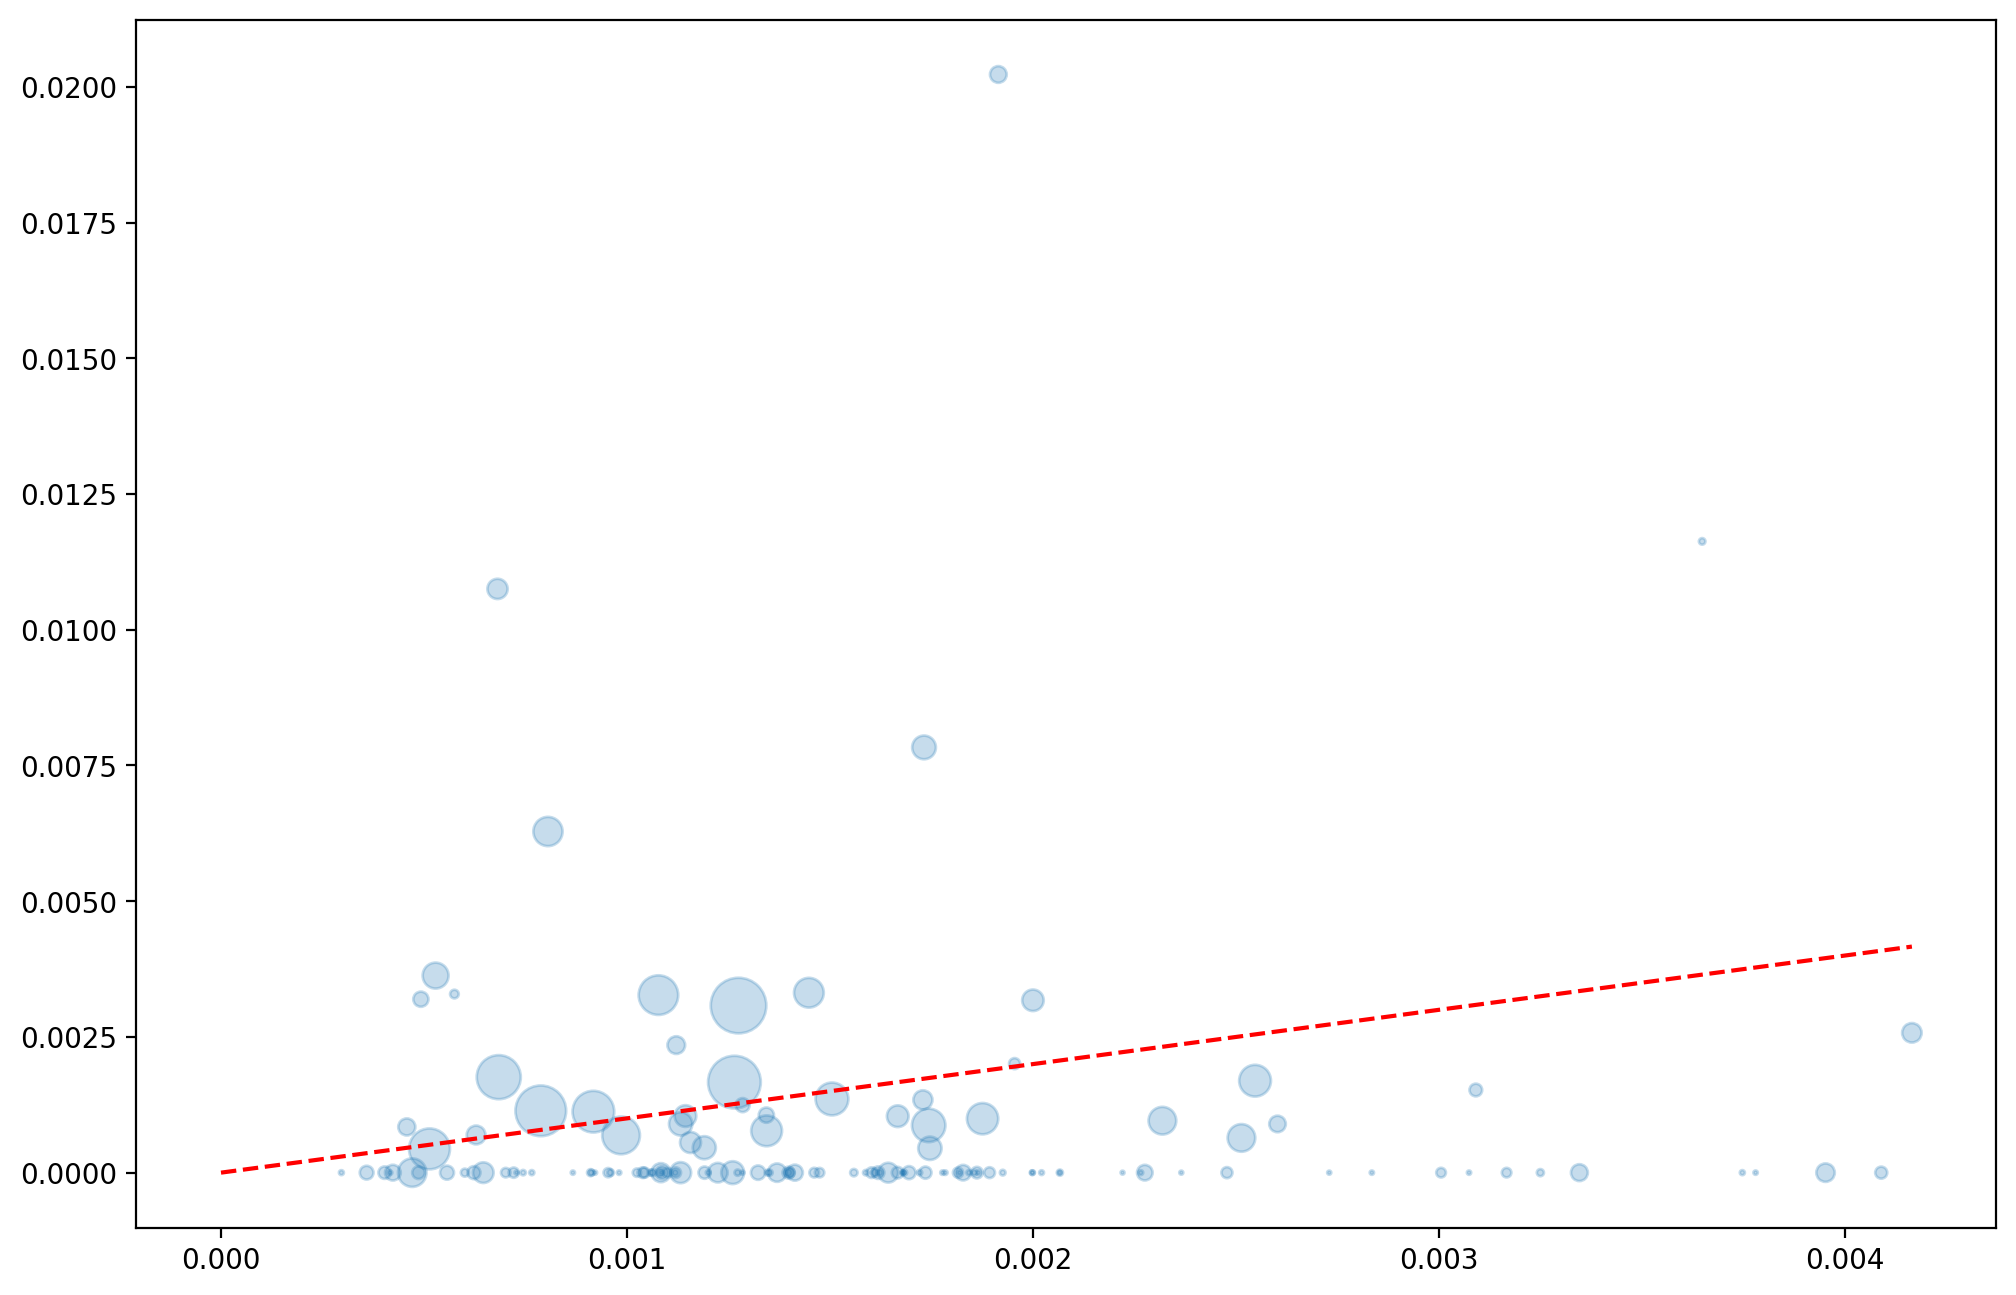

In [155]:
bigger_counties = fuller_data_cty.loc[fuller_data_cty['total_inmate_pop'] > 60]

plt.scatter(bigger_counties['death_rate'], 
            bigger_counties['jail_covid_death_rate'], 
            bigger_counties['total_inmate_pop'] * 400 / bigger_counties['total_inmate_pop'].max(),
            alpha=0.25)
plt.plot([0,bigger_counties['death_rate'].max()],
         [0,bigger_counties['death_rate'].max()],
         linestyle = 'dashed',
         color = 'red')
plt.show()

In [133]:
fuller_data_cty

,deaths,NAME,POP,Fatalities 12-31-2020,death_rate,year,state,county_name,total_jail_pop,tdcj_number,jail_covid_death_rate
ANDERSON,19.0,"Anderson County, Texas",5.77e+04,73.0,1.26e-03,2018.0,TX,Anderson County,182.00,11215.0,1.67e-03
ANDREWS,0.0,"Andrews County, Texas",1.87e+04,33.0,1.76e-03,2018.0,TX,Andrews County,22.00,0.0,0.00e+00
ANGELINA,23.0,"Angelina County, Texas",8.67e+04,166.0,1.91e-03,2018.0,TX,Angelina County,244.00,893.0,2.02e-02
ARANSAS,0.0,"Aransas County, Texas",2.35e+04,25.0,1.06e-03,2018.0,TX,Aransas County,195.00,0.0,0.00e+00
ARCHER,0.0,"Archer County, Texas",8.55e+03,6.0,7.02e-04,2018.0,TX,Archer County,18.93,0.0,0.00e+00
ARMSTRONG,0.0,"Armstrong County, Texas",1.89e+03,6.0,3.18e-03,2018.0,TX,Armstrong County,3.00,0.0,0.00e+00
ATASCOSA,0.0,"Atascosa County, Texas",5.12e+04,88.0,1.72e-03,2018.0,TX,Atascosa County,114.00,0.0,0.00e+00
AUSTIN,0.0,"Austin County, Texas",3.00e+04,15.0,4.99e-04,2018.0,TX,Austin County,50.00,0.0,0.00e+00
BAILEY,0.0,"Bailey County, Texas",7.00e+03,16.0,2.29e-03,2018.0,TX,Bailey County,41.00,0.0,0.00e+00
BANDERA,0.0,"Bandera County, Texas",2.31e+04,15.0,6.49e-04,2018.0,TX,Bandera County,54.00,0.0,0.00e+00


Convert VERA fips to character

In [46]:
vera_data_pops_late['fips'] = vera_data_pops_late['fips'].astype('str')
vera_data_pops_late['fips'] = vera_data_pops_late['fips'].str.pad(width = 5, side = 'left', fillchar = '0')
vera_for_merge = vera_data_pops_late.copy()[['fips', 'total_jail_pop']]

Summarize COVID deaths by zip and merge on VERA

In [47]:
deaths_by_zip = covid_deaths[['fips_decoded', 'Name']].groupby(['fips_decoded'], as_index=False).count()
deaths_by_zip = deaths_by_zip.rename(columns={'Name': 'deaths'})
deaths_by_zip = deaths_by_zip.set_index('fips_decoded').join(vera_for_merge.set_index('fips'), how = 'left')
deaths_by_zip = deaths_by_zip.reset_index().groupby('index').sum()
deaths_by_zip['death_perc'] = deaths_by_zip['deaths'] / deaths_by_zip['total_jail_pop']
deaths_by_zip['high'] = deaths_by_zip['death_perc'] > .018
deaths_by_zip['diff'] = deaths_by_zip['death_perc'] - .018

In [48]:
deaths_by_zip['high'].value_counts()

False    25
True     24
Name: high, dtype: int64

In [49]:
deaths_by_zip.loc[deaths_by_zip['death_perc'] != np.inf]['diff'].describe()

count    4.80e+01
mean     3.25e-02
std      1.04e-01
min     -1.72e-02
25%     -1.47e-02
50%     -2.24e-03
75%      4.00e-02
max      6.33e-01
Name: diff, dtype: float64

In [ ]:
plt.hist(deaths_by_zip.loc[(deaths_by_zip['death_perc'] != np.inf) & 
                           (deaths_by_zip['death_perc'] < .6)]['diff'], bins = 25)
plt.ylabel('Zip Code')
plt.xlabel('Difference in Estimated Death Rate from 1.8%')
plt.title('Comparison of Death Rate in Jails by County to Texas Long Run Average');